# Intro 

This notebook showcases my modeling for the capstone project. It is broken up into three sections, each one representing an iteration of the project. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

The first thing to do is to read both the training data and the test data. One thing to note about the test data: we don't actually have the right answers. Instead you must submit your answers to Kaggle in order to see what your RMSE between the log of you predicted answers and the log of the actual answers is.

In [2]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

Now that we have our data it's time to generate our first models!

# First Iteration Models

Because Kaggle already tells us about their benchmark model (linear regression with `LotArea`, `BedroomAbvGr`, `MoSold`, and `YrSold`) I thought it made sense to start with my four algorithms only using those four features. This process is detailed below.

First step, let's grab the relevant features, create the feature set and the target set, and examine their relationship and distributions

In [3]:
# Helper function to make splitting features and target easy!
def split_features_target(data): 
    return data.drop('SalePrice', axis=1), data['SalePrice']

In [4]:
first_model_data = train_data[['LotArea', 'BedroomAbvGr', 'MoSold', 'YrSold', 'SalePrice']]
first_model_features, first_model_target = split_features_target(first_model_data)

In [5]:
first_model_data.head()

,LotArea,BedroomAbvGr,MoSold,YrSold,SalePrice
0,8450,3,2,2008,208500
1,9600,3,5,2007,181500
2,11250,3,9,2008,223500
3,9550,3,2,2006,140000
4,14260,4,12,2008,250000


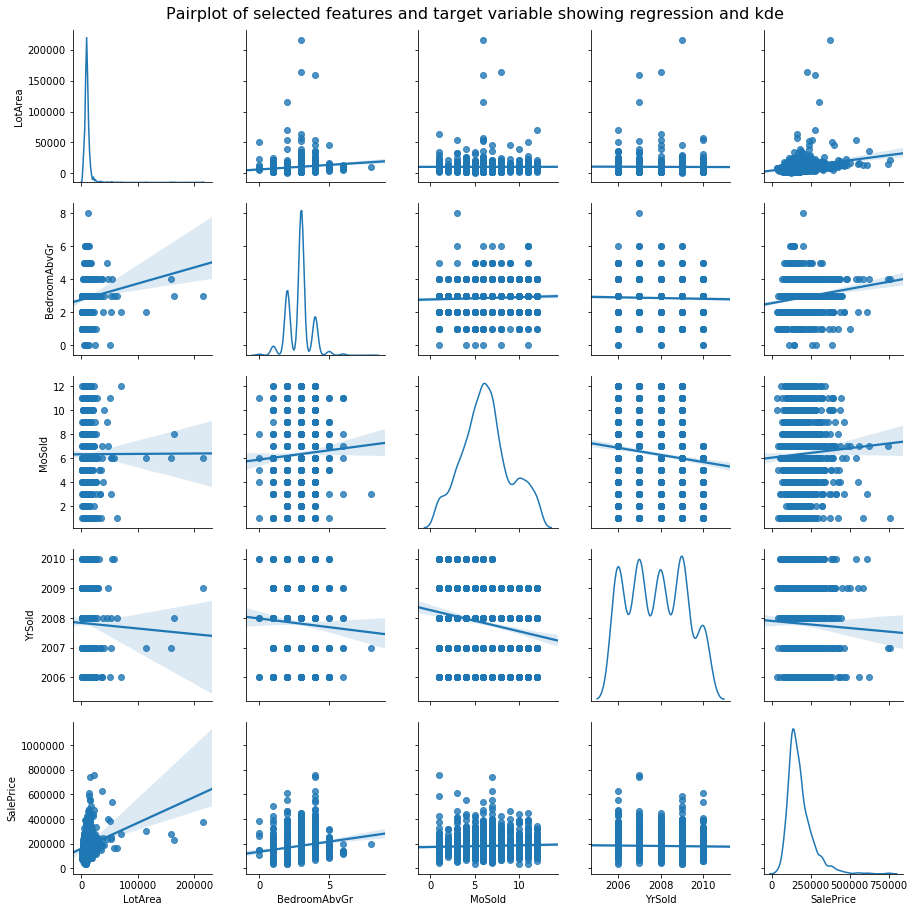

In [6]:
g = sns.pairplot(first_model_data, diag_kind="kde", kind='reg')
g.fig.suptitle("Pairplot of selected features and target variable showing regression and kde", y=1.01, fontsize=16)

As you can see, it appears that `LotArea` and `SalePrice` are the two variables that would benefit from a log transform. Let's go ahead and do that now.

In [7]:
first_model_features['LogLotArea'] = np.log(first_model_features['LotArea'])
first_model_processed_features = first_model_features.drop('LotArea', axis=1)

first_model_processed_target = np.log(first_model_target)

In [8]:
first_model_processed_features.head()

,BedroomAbvGr,MoSold,YrSold,LogLotArea
0,3,2,2008,9.041922
1,3,5,2007,9.169518
2,3,9,2008,9.328123
3,3,2,2006,9.164296
4,4,12,2008,9.565214


In [9]:
first_model_processed_target.head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice, dtype: float64

Yup, it's clear that the log transform has occurred! Now that we have our data transformed, it's time to begin the training. 

The first thing I need to do is create my metrics/performance function. The performance function will be RMSE so generating it is easy, especially if we start with scikit's MSE function: 

In [10]:
# https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python

from sklearn.metrics import mean_squared_error
from math import sqrt

def performance_metric(y_true, y_predict):
    return sqrt(mean_squared_error(y_true, y_predict))

In [11]:
# Quick test to make sure it works -- it does!
performance_metric([1, 2], [0, 0])

1.5811388300841898

Now that we have our performance metric, I created different functions for the various models that we are training. In particular, the function for linear regression was a lot easier to write than the one for the other models as there were no hyperparamters to train. Nevertheless, I still had a validation set (using 20% of the training data) in order to measure an estimated RMSE for the test set as well as compare it with the results from my other models. 

In [12]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

def train_linear_regression(X, y):
    X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=26)
    
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_validate)
    
    return performance_metric(y_validate, y_pred)

In [13]:
import datetime

start = datetime.datetime.now()
lr_result = train_linear_regression(first_model_processed_features, first_model_processed_target)
stop = datetime.datetime.now()

print("Amount of time it took to train model was: %s" % (stop - start))

Amount of time it took to train model was: 0:00:00.004381


In [14]:
lr_result

0.3546942201290472

The RMSE on the validation set for linear regression using these features was 0.35. 

The next function I wrote is the general function used to train decision trees, random forest, and gradient boosting regressor. The nice thing about scikit learn is once you have this setup, it is easy to generalize across many different models. (Thus I was only required to create one function). This function followed the same general pattern as the functino we had to implement for finding doners. It begins with a scoring function followed by splitting the training data into a training set and a validation set. The split used is _exactly the same_ as the one used in linear regression (this will become very important later on). After we have set these properties, we then feed this information along with the model and the parameters to GridSearchCV to find the optimal hyperparameters. We end by returning the best model along with the best score. NOTE: Because we set `greater_is_better=False` the value returned will be negative. That's okay -- we'll just need to multiply by -1 to get the actual RMSE.   

In [15]:
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit

def train_other_models(X, y, regressor, params, performance_metric): 
    # Create a scoring function, making sure to set greater_is_better equal to False (we want to MINIMIZE RMSE)
    scoring_fnc = make_scorer(performance_metric, greater_is_better=False)
    
    # Split the training data into a training set and validation set. This is the same as the one used for 
    # linear regression
    rs = ShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=26)
    
    # Using grid search to identify the optimal hyperparameters for a particular model. 
    # This uses the scoring function and train/validation split defined above. 
    grid = GridSearchCV(regressor, params, scoring=scoring_fnc, cv=rs.split(X), n_jobs=-1)
    grid = grid.fit(X, y)
    
    return grid.best_estimator_, grid.best_score_

The next set of model training follow a same general pattern: I create a dictionary of the hyperparameters first, then I pass the necessary information to the `train_other_models` function. One thing to note is that for every model I set and use the same random_state. I do this to guarantee that if I have to run the code again, I will get the same result--this makes it easier to write the results in my report :)

I begin with decision trees.

In [16]:
dt_hyperparameters = {'max_depth': [depth for depth in range(1, 11)], 
                                 'min_samples_leaf': [min_samples for min_samples in range(1, 16)]}


start = datetime.datetime.now()
dt_result = train_other_models(first_model_processed_features, first_model_processed_target, 
                   DecisionTreeRegressor(random_state=39), dt_hyperparameters, performance_metric)
stop = datetime.datetime.now()

print("Amount of time it took to train model and select optimal hyperparamters was: %s" % (stop - start))

Amount of time it took to train model and select optimal hyperparamters was: 0:00:00.304132


In [17]:
dt_result

(DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=15,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=39, splitter='best'),
 -0.34628721865754586)

Decision trees took a little bit longer to test (but not by much) and the RMSE was 0.346, which was a slight improvement over the linear regression model. 

Let us now examine random forests.

In [18]:
from sklearn.ensemble import RandomForestRegressor

rf_hyperparameters = {'n_estimators': [tree for tree in [10, 25, 100, 200, 500, 1000]],
              'max_depth': [depth for depth in range(1, 11)], 
              'min_samples_leaf': [min_samples for min_samples in range(1, 16)]}

start = datetime.datetime.now()
rf_result = train_other_models(first_model_processed_features, first_model_processed_target, 
                   RandomForestRegressor(random_state=39), rf_hyperparameters, performance_metric)
stop = datetime.datetime.now()

print("Amount of time it took to train model and select optimal hyperparamters was: %s" % (stop - start))

Amount of time it took to train model and select optimal hyperparamters was: 0:01:37.215822


In [19]:
rf_result = train_other_models(X=first_model_processed_features, 
                               y=first_model_processed_target, 
                               regressor=RandomForestRegressor(random_state=39), 
                               params=rf_hyperparameters, 
                               performance_metric=performance_metric)

In [20]:
rf_result

(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=13, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=39, verbose=0, warm_start=False),
 -0.33765161902197449)

As expected random forest took a lot longer to run than decision trees. This makes sense given we had significantly more hyperparameters to tune. The end result was an RMSE of 0.338, which was again an improvement on our previous best. 

Let us now conclude with gradient boosting regressor

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

gb_hyperparameters = {'loss': ['ls', 'lad', 'huber'],
                      'learning_rate': [0.01, 0.1, 1],
                      'n_estimators': [100, 200, 500],
                      'max_depth': [depth for depth in range(1, 11)], 
                      'min_samples_leaf': [min_samples for min_samples in range(1, 16)]}

start = datetime.datetime.now()
gb_result = train_other_models(first_model_processed_features, first_model_processed_target, 
                   GradientBoostingRegressor(random_state=39), gb_hyperparameters, performance_metric)
stop = datetime.datetime.now()

print("Amount of time it took to train model and select optimal hyperparamters was: %s" % (stop - start))

Amount of time it took to train model and select optimal hyperparamters was: 0:09:00.793816


In [22]:
gb_result

(GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='lad', max_depth=7,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=14, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=39, subsample=1.0, verbose=0,
              warm_start=False), -0.33375280957714815)

Given that gradient boosting regressor had even more hyperparameters than random forests, it should be no surprise that grid search took even longer. In the end the RMSE was 0.334, which was marginally better than our previous best. Thus, I decided to select this model as my initial benchmark. 

Now that I had this inital model, I decided to go back and train the model on the entire dataset. 

In [23]:
gb_model = GradientBoostingRegressor(alpha=0.9, loss='lad', max_depth=7, min_samples_leaf=14, 
                                     learning_rate=0.1, random_state=39, n_estimators=500)
gb_model.fit(first_model_processed_features, first_model_processed_target)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=7, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=14,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=39,
             subsample=1.0, verbose=0, warm_start=False)

From there, I used the model to predict the log(SalePrice) of the test data. To do that, I had to extract the correct features and log transform `LotArea` as well. 

In [24]:
first_model_test_features = test_data[['LotArea', 'BedroomAbvGr', 'MoSold', 'YrSold']]

first_model_test_features['LogLotArea'] = np.log(first_model_test_features['LotArea'])
first_model_processed_test_features = first_model_test_features.drop('LotArea', axis=1)

/Users/mihaimsirbu/anaconda/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
first_model_processed_test_features.head()

,BedroomAbvGr,MoSold,YrSold,LogLotArea
0,2,6,2010,9.360655
1,3,6,2010,9.565704
2,3,3,2010,9.534595
3,3,6,2010,9.208138
4,2,1,2010,8.518193


From there, I used it to predict the log(SalePrice) of the test data. 

In [26]:
predicted_test_results = gb_model.predict(first_model_processed_test_features)

Because Kaggle requires the results to be in actual dollar amounts, I had to untransform my predictions. I then wrote those predictions to a csv and submitted it to Kaggle. As always, let's generalize this function for our own sanity!

In [27]:
def transform_and_save_predictions(predictions, filepath):
    # You have to un-log transform the predictions!
    prediction_data = {'Id': range(1461, 1461+len(predictions)), 'SalePrice': np.exp(predictions)}
    predictions_df = pd.DataFrame(prediction_data)
    predictions_df.to_csv(filepath, index=False)

In [28]:
transform_and_save_predictions(predicted_test_results, './data/first_model_prediction.csv')

In [29]:
%%bash 

head ./data/first_model_prediction.csv

Id,SalePrice
1461,146385.32795032076
1462,236896.8068924356
1463,233873.3512595826
1464,163009.10744909276
1465,164232.95088840046
1466,165567.49571445712
1467,139783.668897826
1468,145842.08547168004
1469,143598.42774726736


Looks good to me! When I submitted it to Kaggle, my RMSE between the log of my predictions and the log of the actual answer was 0.37041, which was an improvement from 0.40890!

# Refinement

Although we had made improvement, I still felt like I could do a better job. Thus, it was time to refine the model. To do this, I made several changes. First, I decided to stop using linear regression as a potential model; this was done because I felt linear regression had too high bias for this problem. Second, I added a few more values to certain hyperparameters within random forest and gradient boosting regressors. You will see the difference below. Third, I decided to add more features. 

The first feature I decided to add was `Neighborhood`, which is a categorical feature. This was done based on EDA and my intution of certain neighborhoods being desirable. To be able to include it, however, I had to perform one-hot enconding; this will be seen later on. 

The second set of features I wanted to add was the top 4 or 5 features that were most correlated with `SalePrice`. In order to _properly_ identify such features, I made sure to determine correlations only using the same training set as my model training functions. In other words, I did NOT determine correlations using the entire training set but rather with the new training set (80% of the original) after the train/validate split. For reasons why this is the correct way of doing things, check out [this video](https://www.youtube.com/watch?v=S06JpVoNaA0)

In [30]:
# First get only the continuous columns (drop Id)
continuous_cols = train_data.columns[train_data.dtypes != object]
continuous_data = train_data[continuous_cols]
continuous_data = continuous_data.drop('Id', axis=1)

continuous_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


Although we had the continuous data, we were not done. We had to now extract only the data that was associated with our new train set (80% of the original training data). To do that I created a helper function to do just that. First, I split the data into features and target. Then I run the `train_test_split` function. Once I have the components, I then stitch X_train and y_train back together and return the new create new training subset data. The output of this function will be used on more than one occasion. 

In [31]:
def create_new_train_subset(data): 
    X = data.drop('SalePrice', axis=1)
    y = data['SalePrice']
    
    X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=26)
    new_train_subset = X_train.copy(deep=True)
    
    # Includes all continuous features and the target variable
    new_train_subset['SalePrice'] = y_train
    
    return new_train_subset

 From here, creating a correlation matrix was straightforward

In [32]:
continuous_train_data = create_new_train_subset(continuous_data)
corr_matrix = continuous_train_data.corr()
corr_matrix['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.797377
GrLivArea        0.718194
TotalBsmtSF      0.651546
GarageCars       0.647715
GarageArea       0.639467
1stFlrSF         0.628965
FullBath         0.565811
YearBuilt        0.541140
TotRmsAbvGrd     0.538015
YearRemodAdd     0.516331
GarageYrBlt      0.500987
MasVnrArea       0.482830
Fireplaces       0.466124
BsmtFinSF1       0.407889
LotFrontage      0.360956
WoodDeckSF       0.309869
2ndFlrSF         0.305539
OpenPorchSF      0.279858
HalfBath         0.266104
LotArea          0.255151
BsmtUnfSF        0.219645
BsmtFullBath     0.212919
BedroomAbvGr     0.164985
PoolArea         0.106169
ScreenPorch      0.101591
3SsnPorch        0.038541
MoSold           0.038228
BsmtFinSF2      -0.004927
BsmtHalfBath    -0.023287
MiscVal         -0.028023
YrSold          -0.037429
LowQualFinSF    -0.067444
OverallCond     -0.100032
MSSubClass      -0.104662
EnclosedPorch   -0.123270
KitchenAbvGr    -0.143213
Name: SalePrice, dtype: float64

(Related aside: This might not be easy to see, but if you compared this result with the correlations using the entire training set, the order is slightly different! Here the top five correlated features with `SalePrice` are, in order of highest to lowest correlation, `OverallQual`, `GrLivArea`, `TotalBsmtSF`, `GarageCars`, `GarageArea`. On the other hand, if you examine the correlations using the entire training set the top five correlated features with `SalePrice` are, in order of highest to lowest correlation, `OverallQual`, `GrLivArea`, `GarageCars`, `GarageArea`, and `TotalBsmtSF`)

Based upon this I decided to add the two features whose correlations were above 0.7, which were `OverallQual` and `GrLivArea`. Before continuing with our actual model training, however, there were two additional things to examine. First, was whether either feature required log transformation. I determined this by using pairplots 

In [33]:
pairplot_test = continuous_train_data[['OverallQual', 'GrLivArea', 'SalePrice']]

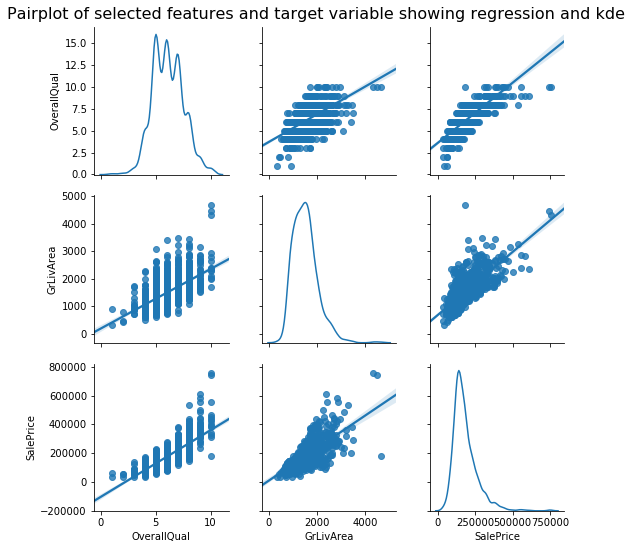

In [34]:
g = sns.pairplot(pairplot_test, diag_kind="kde", kind='reg')
g.fig.suptitle("Pairplot of selected features and target variable showing regression and kde", y=1.01, fontsize=16)

From this, it appers that `GrLivArea` will need to be log transformed. (SalePrice had already been identified as requiring log transform)

Finally, before actually creating the models, I decided to examine the collinearity between all the continuous features that we are planning on using:

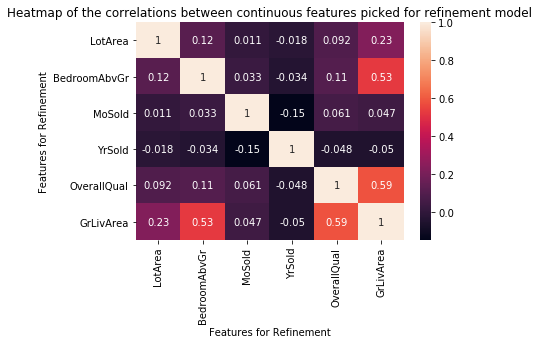

In [35]:
collinearity_check = continuous_train_data[['LotArea', 'BedroomAbvGr', 'MoSold', 'YrSold', 'OverallQual', 'GrLivArea']]
sns.heatmap(collinearity_check.corr(), annot=True).set_title('Heatmap of the correlations between continuous features picked for refinement model') 
plt.xlabel('Features for Refinement') 
plt.ylabel('Features for Refinement')

The highest correlations were between `OverallQual` and `GrLivArea` (0.59) and `BedroomAbvGr` and `GrLivArea`. However, none of them seemed too troubling so I diecdied to use everything as before. 

## Refinement model training

With that, it was now time to begin the model training process again. The first step was to select the right featuers

In [36]:
second_model_data = train_data[['LotArea', 'BedroomAbvGr', 'MoSold', 'YrSold', 
                               'OverallQual', 'GrLivArea', 'Neighborhood', 'SalePrice']]
second_model_features, second_model_target = split_features_target(second_model_data)

Then it was time to do the necessary data transformations, starting with the log transform. At this point, I decided to create a function. NOTE: The add_value is for cases wehre some values are 0 and we need to add a 1 in order for log transform to work properly.

In [37]:
def log_transform_features(data, columns, add_value=False): 
    value = 1 if add_value else 0
    
    for c in columns: 
        data['Log'+c] = data[c].apply(lambda x: np.log(x + value))
        data = data.drop(c, axis=1)
        
    return data

In [38]:
second_model_processed_continuous_features = log_transform_features(second_model_features, 
                                                                    ['LotArea', 'GrLivArea'])

We took care of the continuous features, now it's time to take care of the categorical feature, which required one-hot encoding.

In [39]:
second_model_processed_features = pd.get_dummies(second_model_processed_continuous_features)
second_model_processed_features.head()

,BedroomAbvGr,MoSold,YrSold,OverallQual,LogLotArea,LogGrLivArea,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,3,2,2008,7,9.041922,7.444249,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,5,2007,6,9.169518,7.140453,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,9,2008,7,9.328123,7.487734,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,2,2006,7,9.164296,7.448334,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,12,2008,8,9.565214,7.695303,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [40]:
second_model_processed_target = np.log(second_model_target)
second_model_processed_target.head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice, dtype: float64

Preprocessing all done! Now it's time to actually train those model across the various hyperparameters!

In [41]:
second_dt_hyperparameters = {'max_depth': [depth for depth in range(1, 11)], 
                                 'min_samples_leaf': [min_samples for min_samples in range(1, 16)]}


start = datetime.datetime.now()
second_dt_result = train_other_models(second_model_processed_features, second_model_processed_target, 
                   DecisionTreeRegressor(random_state=39), second_dt_hyperparameters, performance_metric)
stop = datetime.datetime.now()

print("Amount of time it took to train model and select optimal hyperparamters was: %s" % (stop - start))

Amount of time it took to train model and select optimal hyperparamters was: 0:00:00.439064


In [42]:
second_dt_result

(DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=15,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=39, splitter='best'),
 -0.20753621627944754)

Huzah! By adding these three additional features, our new RMSE for decision trees is 0.207. This appears to be quite the improvement over our last model's decision tree result which had an RMSE of 0.346. Now lets move to using grid search to find the best random forest model. 

One thing to note here is that we have added some additional values to `n_estimators` hyperparameter for grid search to explore. 

In [43]:
second_rf_hyperparameters = {'n_estimators': [tree for tree in [10, 25, 50, 75, 100, 200, 500, 1000]],
              'max_depth': [depth for depth in range(1, 11)], 
              'min_samples_leaf': [min_samples for min_samples in range(1, 16)]}

start = datetime.datetime.now()
second_rf_result = train_other_models(second_model_processed_features, second_model_processed_target, 
                   RandomForestRegressor(random_state=39), second_rf_hyperparameters, performance_metric)
stop = datetime.datetime.now()

print("Amount of time it took to train model and select optimal hyperparamters was: %s" % (stop - start))

Amount of time it took to train model and select optimal hyperparamters was: 0:02:14.646890


In [44]:
second_rf_result

(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=39, verbose=0, warm_start=False),
 -0.18364244710019687)

Like the first case, random forest performed better than a single decision tree with an RMSE of 0.184. This is not surprising. What is impressive, however, is the drop from an RMSE of 0.337 to an RMSE of 0.184 just by using three additional features. 

In [45]:
second_gb_hyperparameters = {'loss': ['ls', 'lad', 'huber'],
                      'learning_rate': [0.01, 0.1, 1],
                      'n_estimators': [100, 200, 300, 500, 700, 1000],
                      'max_depth': [depth for depth in range(1, 11)], 
                      'min_samples_leaf': [min_samples for min_samples in range(1, 16)]}

start = datetime.datetime.now()
second_gb_result = train_other_models(second_model_processed_features, second_model_processed_target, 
                   GradientBoostingRegressor(random_state=39), second_gb_hyperparameters, performance_metric)
stop = datetime.datetime.now()

print("Amount of time it took to train model and select optimal hyperparamters was: %s" % (stop - start))

Amount of time it took to train model and select optimal hyperparamters was: 0:43:05.839456


In [46]:
second_gb_result

(GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='lad', max_depth=4, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=39,
              subsample=1.0, verbose=0, warm_start=False),
 -0.16492291492837186)

This took significantly longer than I expected but, then again, we added more features and more values for `n_estimators`. In any event, like the other two models, the RMSE did decrease dramatically from the first gradient boosting iteration. RMSE dropped from 0.334 to 0.165! 

Once again, the best graident boosting regressor model was the best model relative to random forests and decision trees so I went ahead and chose this model. Thus, like before, I went back and trained the model on the entire training dataset (making sure to do the necessary preprocessing), predicted on the test set and submitted my results to Kaggle.

In [47]:
gb_model = GradientBoostingRegressor(alpha=0.9, loss='lad', max_depth=4, min_samples_leaf=1, 
                                     learning_rate=0.1, random_state=39, n_estimators=200)
gb_model.fit(second_model_processed_features, second_model_processed_target)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=39,
             subsample=1.0, verbose=0, warm_start=False)

In [48]:
second_model_test_features = test_data[['LotArea', 'BedroomAbvGr', 'MoSold', 'YrSold', 
                               'OverallQual', 'GrLivArea', 'Neighborhood']]

second_model_processed_test_cont_features = log_transform_features(second_model_test_features, ['LotArea', 'GrLivArea'])
second_model_processed_test_features = pd.get_dummies(second_model_processed_test_cont_features)

second_model_processed_test_features.head()

/Users/mihaimsirbu/anaconda/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,BedroomAbvGr,MoSold,YrSold,OverallQual,LogLotArea,LogGrLivArea,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,2,6,2010,5,9.360655,6.797940,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,6,2010,6,9.565704,7.192182,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,3,2010,5,9.534595,7.395722,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,6,2010,6,9.208138,7.380256,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,1,2010,8,8.518193,7.154615,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [49]:
predicted_second_test_results = gb_model.predict(second_model_processed_test_features)
transform_and_save_predictions(predicted_second_test_results, './data/second_model_prediction.csv')

In [50]:
%%bash 

head ./data/second_model_prediction.csv

Id,SalePrice
1461,125773.5649270249
1462,163483.51897126198
1463,155115.04423417107
1464,177935.90225907348
1465,201881.0980200685
1466,176436.8105387248
1467,152001.94301229934
1468,172093.68522900506
1469,185448.9520800501


Everything looks good! After submitting my results to Kaggle, I got a final test RMSE of 0.17588, a major improvement from my initial benchmark and the Kaggle benchmark! 

# Second Refinement 

While my refined model had major improvement over my initial model, I still felt I could do better with minimal tweaks. Thus, I decided to add more features. Based on my EDA, I decided to add three more categorical features: `ExterQual`, `BsmtQual`, `KitchenQual`. These features, like `Neighborhood` would need to be transformed via one-hot encoding. 

Now one thing that was different about these three features relative to the other one was there `BsmtQual` actually had some null values associated with it. 

In [51]:
# Number of null values in the training subset (80% of the original training set)
cat_train_data = create_new_train_subset(train_data[['ExterQual', 'BsmtQual', 'KitchenQual', 'SalePrice']])
cat_train_data.isnull().sum()

ExterQual       0
BsmtQual       31
KitchenQual     0
SalePrice       0
dtype: int64

In [52]:
# Number of nulls across the entire training set
train_data[['ExterQual', 'BsmtQual', 'KitchenQual']].isnull().sum()

ExterQual       0
BsmtQual       37
KitchenQual     0
dtype: int64

In this case I have decided to let the null serve as an additional level in the cateogrical feature. 

Besides categorical features, I also decided to add all continuous features that had a correlation higher than 0.60 with `SalePrice` from the training subset (e.g. 80% of the original training data). This included `TotalBsmtSF`, `GarageCars`, `GarageArea`, and `1stFlrSF`. Of course, before throwing them into my model I had to check two things: (1) whether any of the features required log transformation, and (2) whether there were any issues with collinearity. 

To check if any new continuous features required log transformation, I used the same method as before--namely looking at the distibutions via a pairplot. 

In [53]:
pairplot_test = continuous_train_data[['TotalBsmtSF', 'GarageCars', 'GarageArea', '1stFlrSF', 'SalePrice']]

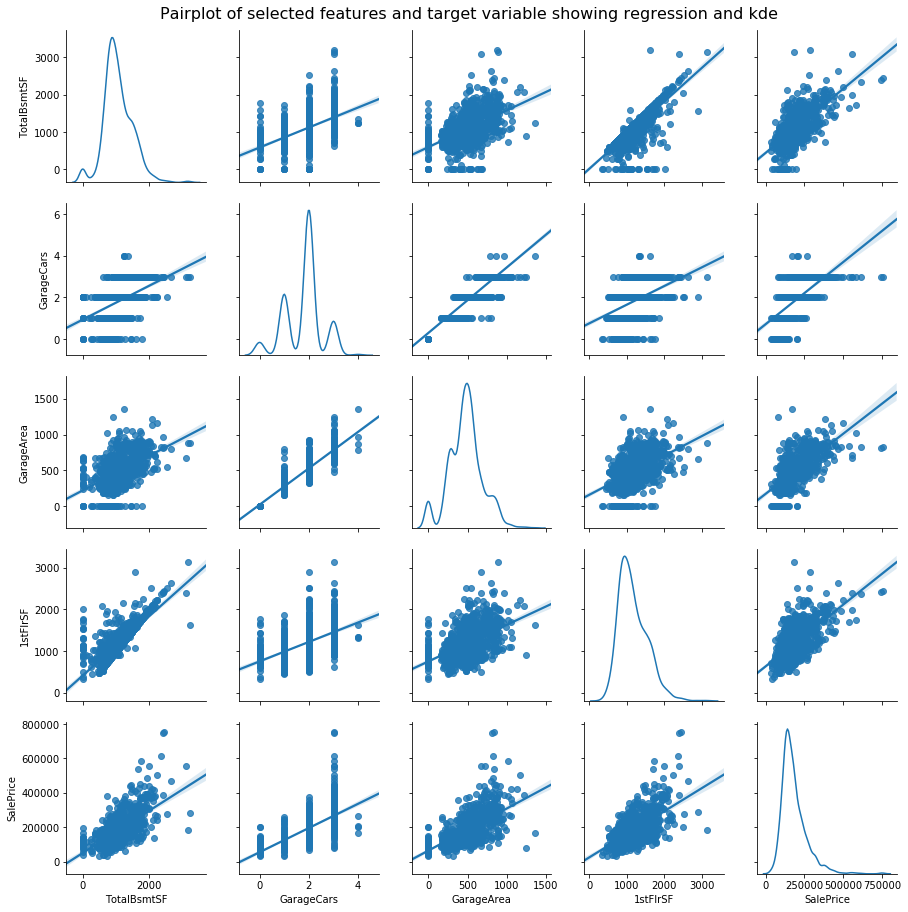

In [54]:
g = sns.pairplot(pairplot_test, diag_kind="kde", kind='reg')
g.fig.suptitle("Pairplot of selected features and target variable showing regression and kde", y=1.01, fontsize=16)

Based on this pairplot, it appears that `1stFlrSF` and `TotalBsmtSF` require log transformation. 

And what about collinearity? Again, to check that we can plot a heatmap of the correlations, again making sure to ONLY USING THE TRAINING SUBSET (80% of the original training data) to avoid leakage. 

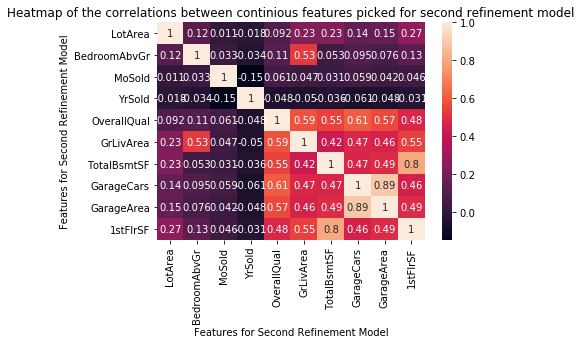

In [55]:
collinearity_check = continuous_train_data[['LotArea', 'BedroomAbvGr', 'MoSold', 'YrSold', 'OverallQual', 
                                           'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'GarageArea', '1stFlrSF']]

sns.heatmap(collinearity_check.corr(), annot=True).set_title('Heatmap of the correlations between continious features picked for second refinement model') 
plt.xlabel('Features for Second Refinement Model') 
plt.ylabel('Features for Second Refinement Model')

Based on this correlation matrix, it appreas that `TotalBsmtSF` and `1stFlrSF` are highly correlated (0.8) as are `GarageCars` and `GarageArea` (0.89). Given this, I do not believe it makes sense to include all four features in my model. Thus, I will only include the one feature from each pair that has the highest correlation with `SalePrice`. From the calculation done above, that would be `TotalBsmtSF` and `GarageCars`. 

Now that we have identified the features we wish to add, it is now time to actually prepare the data for model training and hyperparameter tuning.

In [56]:
third_model_data = train_data[['LotArea', 'BedroomAbvGr', 'MoSold', 'YrSold', 
                               'OverallQual', 'GrLivArea', 'Neighborhood', 
                               'TotalBsmtSF', 'GarageCars', 'ExterQual', 
                               'BsmtQual', 'KitchenQual', 'SalePrice']]
third_model_features, third_model_target = split_features_target(third_model_data)

In [57]:
# Because of the new feature `TotalBsmtSF`, we had to add +1 because some of those values are 0 to properly do
# log conversion!
third_model_processed_continuous_features = log_transform_features(third_model_features, 
                                                                   ['LotArea', 'GrLivArea', 'TotalBsmtSF'], 
                                                                  add_value=True)
third_model_processed_features = pd.get_dummies(third_model_processed_continuous_features)
third_model_processed_features.head()

,BedroomAbvGr,MoSold,YrSold,OverallQual,GarageCars,LogLotArea,LogGrLivArea,LogTotalBsmtSF,Neighborhood_Blmngtn,Neighborhood_Blueste,...,ExterQual_Gd,ExterQual_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA
0,3,2,2008,7,2,9.042040,7.444833,6.753438,0,0,...,1,0,0,0,1,0,0,0,1,0
1,3,5,2007,6,2,9.169623,7.141245,7.141245,0,0,...,0,1,0,0,1,0,0,0,0,1
2,3,9,2008,7,2,9.328212,7.488294,6.825460,0,0,...,1,0,0,0,1,0,0,0,1,0
3,3,2,2006,7,3,9.164401,7.448916,6.629363,0,0,...,0,1,0,0,0,1,0,0,1,0
4,4,12,2008,8,3,9.565284,7.695758,7.044033,0,0,...,1,0,0,0,1,0,0,0,1,0


In [58]:
third_model_processed_target = np.log(third_model_target)
third_model_processed_target.head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice, dtype: float64

Preprocessing all done! Now it's time to actually train those model with this data across the various hyperparameters!

In [59]:
third_dt_hyperparameters = {'max_depth': [depth for depth in range(1, 11)], 
                            'min_samples_leaf': [min_samples for min_samples in range(1, 16)]}


start = datetime.datetime.now()
third_dt_result = train_other_models(third_model_processed_features, third_model_processed_target, 
                   DecisionTreeRegressor(random_state=39), third_dt_hyperparameters, performance_metric)
stop = datetime.datetime.now()

print("Amount of time it took to train model and select optimal hyperparamters was: %s" % (stop - start))

Amount of time it took to train model and select optimal hyperparamters was: 0:00:00.525335


In [60]:
third_dt_result

(DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=9,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=39, splitter='best'),
 -0.19275205273508908)

The updated features brought the RMSE for decision trees from 0.207 to 0.193. Although better, this improvement is much less then when we added `Neighborhood`, `OverallQual`, and `GrLivArea` the first time around. It is also _higher_ than our previous best solution. Training the model was very quick though. 

In [61]:
third_rf_hyperparameters = {'n_estimators': [tree for tree in [10, 25, 50, 75, 100, 200, 500, 1000]],
              'max_depth': [depth for depth in range(1, 11)], 
              'min_samples_leaf': [min_samples for min_samples in range(1, 16)]}

start = datetime.datetime.now()
third_rf_result = train_other_models(third_model_processed_features, third_model_processed_target, 
                   RandomForestRegressor(random_state=39), third_rf_hyperparameters, performance_metric)
stop = datetime.datetime.now()

print("Amount of time it took to train model and select optimal hyperparamters was: %s" % (stop - start))

Amount of time it took to train model and select optimal hyperparamters was: 0:02:41.419349


In [62]:
third_rf_result

(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=39, verbose=0, warm_start=False),
 -0.17405605595364254)

The updated features brough the RMSE for random forest from 0.184 to 0.174. This is the same general pattern as decision trees: specifically, this model showed improvement than the previous one but the improvement from first refined model to second refined model is much less than when we want from our initial model to to the first model. Additionally, like with decision dtrees, this model also appears to be _worse_ than our previous best solution via gradient boosting regressor.  

In [63]:
third_gb_hyperparameters = {'loss': ['ls', 'lad', 'huber'],
                      'learning_rate': [0.01, 0.1, 1],
                      'n_estimators': [100, 200, 300, 500, 700, 1000],
                      'max_depth': [depth for depth in range(1, 11)], 
                      'min_samples_leaf': [min_samples for min_samples in range(1, 16)]}

start = datetime.datetime.now()
third_gb_result = train_other_models(third_model_processed_features, third_model_processed_target, 
                   GradientBoostingRegressor(random_state=39), third_gb_hyperparameters, performance_metric)
stop = datetime.datetime.now()

print("Amount of time it took to train model and select optimal hyperparamters was: %s" % (stop - start))

Amount of time it took to train model and select optimal hyperparamters was: 0:52:59.941771


In [64]:
third_gb_result

(GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='lad', max_depth=3, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=700, presort='auto', random_state=39,
              subsample=1.0, verbose=0, warm_start=False),
 -0.14715954627261341)

Like the other two models, this new gradient boosting model was an improvement from the previous one; validation RMSE dropped from 0.165 to 0.147. Unlike the other two models, however, this model _was_ the best model result of all the model training, tuning, and refinement!

Of the three model testing in this iteration, this was the best one. More importantly, however, this was the best result across all three model iterations. Based on the results, we decided to use the this new updated model as my new model moving forward. Like the two previous iterations, I trained this model -- with these hyperparameters -- on the entire training data and then used the model on the testing data. I then converted my predictions to a csv file and then submitted the results to Kaggle.  

In [65]:
third_gb_model = GradientBoostingRegressor(loss='lad', max_depth=3, min_samples_leaf=1, 
                                     learning_rate=0.1, random_state=39, n_estimators=700)
third_gb_model.fit(third_model_processed_features, third_model_processed_target)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=700, presort='auto', random_state=39,
             subsample=1.0, verbose=0, warm_start=False)

Now you might think this is the way to do this, but you'd be wrong: 

In [66]:
third_model_test_features = test_data[['LotArea', 'BedroomAbvGr', 'MoSold', 'YrSold', 
                                       'OverallQual', 'GrLivArea', 'Neighborhood', 
                                       'TotalBsmtSF', 'GarageCars', 'ExterQual', 
                                       'BsmtQual', 'KitchenQual']]

# TotalBsmtSF can sometimes be 0 so we must add 1
wrong_third_model_processed_test_cont_features = log_transform_features(third_model_test_features, 
                                                                  ['LotArea', 'GrLivArea', 'TotalBsmtSF'], 
                                                                 add_value=True)
wrong_third_model_processed_test_features = pd.get_dummies(wrong_third_model_processed_test_cont_features)
wrong_third_model_processed_test_features.head()

/Users/mihaimsirbu/anaconda/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,BedroomAbvGr,MoSold,YrSold,OverallQual,GarageCars,LogLotArea,LogGrLivArea,LogTotalBsmtSF,Neighborhood_Blmngtn,Neighborhood_Blueste,...,ExterQual_Gd,ExterQual_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA
0,2,6,2010,5,1.0,9.360741,6.799056,6.783325,0,0,...,0,1,0,0,0,1,0,0,0,1
1,3,6,2010,6,1.0,9.565775,7.192934,7.192934,0,0,...,0,1,0,0,0,1,0,0,1,0
2,3,3,2010,5,2.0,9.534668,7.396335,6.834109,0,0,...,0,1,0,0,1,0,0,0,0,1
3,3,6,2010,6,2.0,9.208238,7.380879,6.831954,0,0,...,0,1,0,0,0,1,0,0,1,0
4,2,1,2010,8,2.0,8.518392,7.155396,7.155396,0,0,...,1,0,0,0,1,0,0,0,1,0


At this point, we might be tempted to run something like this but this is not correct: 

In [67]:
# This will fail!

#predicted_third_test_results = gb_model.predict(third_model_processed_test_features)
#transform_and_save_predictions(predicted_third_test_results, './data/third_model_prediction.csv')

The reason this won't work is because there are some null values that must be taken care of as shown below. 

In [68]:
null_counts = third_model_test_features.isnull().sum()
null_counts[null_counts > 0]

TotalBsmtSF     1
GarageCars      1
BsmtQual       44
KitchenQual     1
dtype: int64

As you can see, `TotalBsmtSF` has 1 null value, `GarageCars` has 1 null value, `BsmtQual` has 44 null values, and `KitchenQual` has 1 null value as well. Of these four, we don't have to worry about `BsmtQual` because null was a potential label that the model saw for that feature (In this case, it would be represented as four zero for the four non-null values). The other three column values must be filled with imputation.

Let's start with the continous feature first

In [69]:
third_model_test_features[third_model_test_features['GarageCars'].isnull() | 
                          third_model_test_features['TotalBsmtSF'].isnull()]

,LotArea,BedroomAbvGr,MoSold,YrSold,OverallQual,GrLivArea,Neighborhood,TotalBsmtSF,GarageCars,ExterQual,BsmtQual,KitchenQual,LogLotArea
660,5940,2,4,2008,4,896,BrkSide,NaN,1.0,TA,NaN,TA,8.689633
1116,9060,3,3,2007,5,1828,IDOTRR,859.0,NaN,TA,Gd,Gd,9.111735


As you can see, two different rows are plagued by this null. Let's figure out the general statistics for both columns to see how the values vary here. 

In [70]:
third_model_test_features[['GarageCars', 'TotalBsmtSF']].describe()

,GarageCars,TotalBsmtSF
count,1458.000000,1458.000000
mean,1.766118,1046.117970
std,0.775945,442.898624
min,0.000000,0.000000
25%,1.000000,784.000000
50%,2.000000,988.000000
75%,2.000000,1305.000000
max,5.000000,5095.000000


As you can see, there are a lot of options here. I can use mean, min, median, etc. I personally think that this shouldn't play a huge deal so I am just going to go with mean (but I can test this later on in a different section). However, notice that we were examining the **ORIGINAL** feature distribution. `TotalBsmtSF` is log transformed. Thus we must go back and apply imputation first and then do the log transform. 

Before we get that, however, we also need to examine the row that has a null `KitchenQual`. That row is below:

In [71]:
third_model_test_features[third_model_test_features['KitchenQual'].isnull()]

,LotArea,BedroomAbvGr,MoSold,YrSold,OverallQual,GrLivArea,Neighborhood,TotalBsmtSF,GarageCars,ExterQual,BsmtQual,KitchenQual,LogLotArea
95,10632,3,1,2010,5,1224,ClearCr,689.0,1.0,TA,Gd,NaN,9.271718


How to fill this null? Well we could again look at the distributions of KitchenQual and see what the most common one is:

In [72]:
third_model_test_features['KitchenQual'].value_counts()

TA    757
Gd    565
Ex    105
Fa     31
Name: KitchenQual, dtype: int64

It appears that `TA` and `GD` are the most common values. We could apply the most. But could we go one step further? I think we can. Sepcifically, I think we can use the other features to help us narrow down possible options as I will demonstrate below by using additional features to help: 

In [73]:
predicate = (third_model_test_features['Neighborhood'] == 'ClearCr') &  \
            (third_model_test_features['ExterQual'] == 'TA') & \
            (third_model_test_features['BedroomAbvGr'] == 3) 
        
filtered_data = third_model_test_features[predicate]
filtered_data['KitchenQual'].value_counts()

TA    5
Name: KitchenQual, dtype: int64

We can now fill in that data with TA! (Seems reasonable given all of the other options)

In [74]:
third_model_fillna_features = third_model_test_features.fillna(third_model_test_features.mean())
third_model_fillna_features['KitchenQual'] = third_model_test_features['KitchenQual'].fillna('TA')

With that we can now see how many columns have null (it should only be `BsmtQual` now!)

In [75]:
third_model_fillna_features.isnull().sum()

LotArea          0
BedroomAbvGr     0
MoSold           0
YrSold           0
OverallQual      0
GrLivArea        0
Neighborhood     0
TotalBsmtSF      0
GarageCars       0
ExterQual        0
BsmtQual        44
KitchenQual      0
LogLotArea       0
dtype: int64

Now it's time for us to go back and actually take care of the log transform and get ready to actually test the model!

In [76]:
# TotalBsmtSF can sometimes be 0 so we must add 1
third_model_processed_test_cont_features = log_transform_features(third_model_fillna_features, 
                                                                  ['LotArea', 'GrLivArea', 'TotalBsmtSF'], 
                                                                 add_value=True)
third_model_processed_test_features = pd.get_dummies(third_model_processed_test_cont_features)
third_model_processed_test_features.head()

,BedroomAbvGr,MoSold,YrSold,OverallQual,GarageCars,LogLotArea,LogGrLivArea,LogTotalBsmtSF,Neighborhood_Blmngtn,Neighborhood_Blueste,...,ExterQual_Gd,ExterQual_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA
0,2,6,2010,5,1.0,9.360741,6.799056,6.783325,0,0,...,0,1,0,0,0,1,0,0,0,1
1,3,6,2010,6,1.0,9.565775,7.192934,7.192934,0,0,...,0,1,0,0,0,1,0,0,1,0
2,3,3,2010,5,2.0,9.534668,7.396335,6.834109,0,0,...,0,1,0,0,1,0,0,0,0,1
3,3,6,2010,6,2.0,9.208238,7.380879,6.831954,0,0,...,0,1,0,0,0,1,0,0,1,0
4,2,1,2010,8,2.0,8.518392,7.155396,7.155396,0,0,...,1,0,0,0,1,0,0,0,1,0


In [77]:
predicted_third_test_results = third_gb_model.predict(third_model_processed_test_features)
transform_and_save_predictions(predicted_third_test_results, './data/third_model_prediction.csv')

When I submitted my results to Kaggle, the test RMSE was 0.15922. This was by far the best performance of all the model iterations that I ran!

# Conclusions

Over the course of my model creation process I went through three model iterations with various features in each one. Within each iteration, I created three separate models and ran grid search + train/validation to find the best model with the best hyperparameters. Over the course of this process, my model improved repeatedly from an initial test RMSE to 0.37041 to a final test RMSE of 0.16073. In every iteration, the gradient boosting regressor model was the best one. Additionally, the biggest improvement came from the first model iteration to the second. 

My best model was a gradient boosting regressor with the following features: 
*`LotArea`, (Log transform) 
*`BedroomAbvGr`,  
*`MoSold`, 
*`YrSold`, 
*`OverallQual`, 
*`GrLivArea`, (Log transform)
*`Neighborhood`, 
*`TotalBsmtSF`, (Log transform)
*`GarageCars`, 
*`ExterQual`, 
*`BsmtQual`, 
*`KitchenQual` 

With the following hyperparameters: 
* `learing_rate` = 0.1
* `loss` = 'lad'
* `max_depth` = 3
* `n_estimators` = 700
* `min_samples_leaf` = 1

It's been quite a process but it's been worth it!